In [1]:
import site
from pathlib import Path
site.addsitedir(str(Path.cwd().parents[2]))


import numpy as np
import torch
import matplotlib.pyplot as plt

from presentation.gherqin.config import DEVICE, DTYPE
from presentation.gherqin.neural_states.complex_rbm import ComplexWaveFunction
from presentation.gherqin.neural_states.pauli import create_dict
from presentation.gherqin.data.tomography import TomographyDataset, RBMTomographyLoader

In [2]:
train_path = "ghz_meas_values.txt"
train_bases_path = "ghz_meas_bases.txt"
psi_path = "ghz_state.txt"
bases_path = "ghz_unique_bases.txt"

torch.manual_seed(1234)

data = TomographyDataset(train_path, psi_path, train_bases_path, bases_path, device=DEVICE)

U = create_dict()
nv = data.num_visible()
nh = nv
nv, nh

(4, 4)

In [3]:
nn_state = ComplexWaveFunction(nv, nh, U, device=DEVICE)

epochs = 15
pos_batch_size = 100
neg_batch_size = pos_batch_size
lr = 1e-1
k = 100
log_every = 5

loader = RBMTomographyLoader(data, pos_batch_size, neg_batch_size, device=DEVICE, dtype=DTYPE)

space = nn_state.generate_hilbert_space()
history = nn_state.fit(
    loader,
    epochs=epochs,
    k=k,
    lr=lr,
    log_every=log_every,
    target=data.target(),
    bases=data.eval_bases(),
    space=space,
    print_metrics=True,
    metric_fmt="Epoch {ep}: Fidelity = {fid:.6f} | KL = {kl:.6f}",
)

history.keys()

Epoch 5: Fidelity = 0.023392 | KL = 0.943894
Epoch 10: Fidelity = 0.050025 | KL = 0.821599
Epoch 15: Fidelity = 0.757674 | KL = 0.228452


dict_keys(['epoch', 'Fidelity', 'KL'])

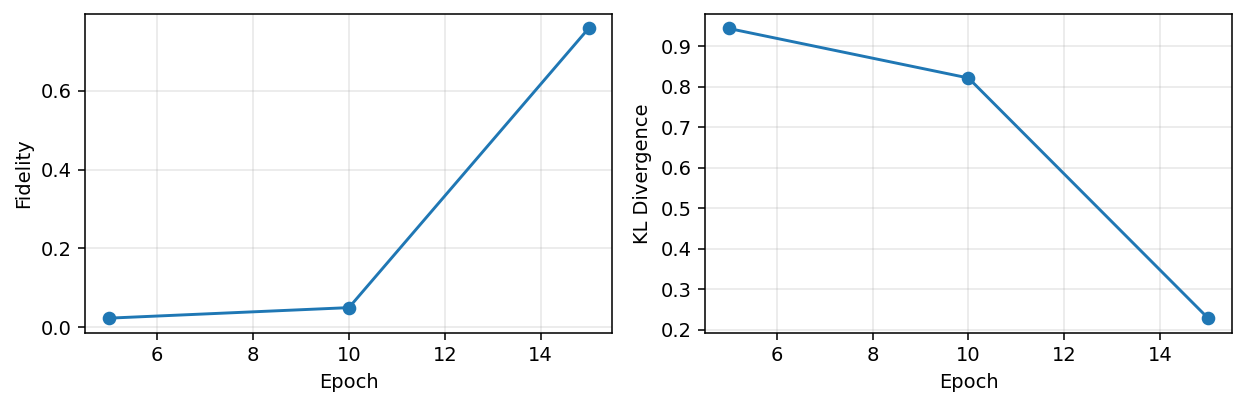

In [4]:
ep  = history.get("epoch", [])
fid = history.get("Fidelity", [])
kls = history.get("KL", [])

fig, axs = plt.subplots(1, 2, figsize=(9, 3.0), dpi=140)

axs[0].plot(ep, fid, 'o', linestyle="-")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Fidelity")

axs[1].plot(ep, kls, 'o', linestyle="-")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("KL Divergence")

for ax in axs: ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Corner indices for GHZ: |00...0> and |11...1>
N = 1 << nv
all_up_down_indices = torch.tensor([0, N - 1], device=DEVICE)

tgt = data.target().to(device=DEVICE, dtype=torch.cdouble)
comp = tgt[all_up_down_indices]

true_phases_raw = torch.angle(comp)
true_phases_wrapped = (true_phases_raw - true_phases_raw[0]) % (2 * torch.pi)

# ---- Predicted phases on the same two states ----
full_hilbert_space = nn_state.generate_hilbert_space()
all_up_down_hilbert_space = full_hilbert_space[all_up_down_indices, :]

pred_phases_raw = nn_state.phase(all_up_down_hilbert_space)
pred_phases_wrapped = (pred_phases_raw - pred_phases_raw[0]) % (2 * torch.pi)

true_phases_wrapped, pred_phases_wrapped

(tensor([0.0000, 4.1717], dtype=torch.float64),
 tensor([0.0000, 4.3650], dtype=torch.float64))

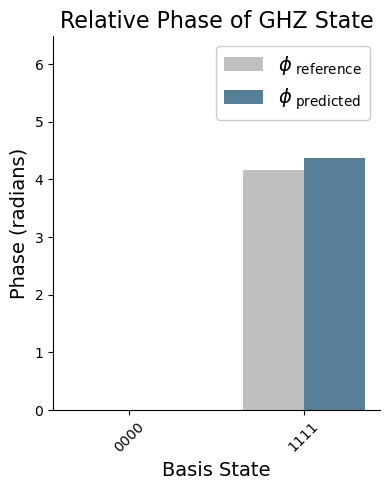

In [7]:
soft_gray = '#b0b0b0'
bdazzled_blue = '#2e5f7f'

bitstrings = ["".join(str(int(b)) for b in row) for row in all_up_down_hilbert_space.numpy()]
indices = np.arange(len(pred_phases_wrapped))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 5), facecolor='white')
ax.set_facecolor('white')

# Bar plots
ax.bar(indices - width/2, true_phases_wrapped, width, alpha=0.8,
       color=soft_gray, label=r'$\phi_{\ \mathrm{reference}}$', zorder=1)
ax.bar(indices + width/2, pred_phases_wrapped, width, alpha=0.8,
       color=bdazzled_blue, label=r'$\phi_{\ \mathrm{predicted}}$', zorder=2)

# Labels and title
ax.set_xlabel("Basis State", fontsize=14)
ax.set_ylabel("Phase (radians)", fontsize=14)
ax.set_title(r"Relative Phase of GHZ State", fontsize=16)

ax.set_xticks(indices)
ax.set_xticklabels([f"${b}$" for b in bitstrings], rotation=45)

ax.set_ylim(0, 2 * np.pi + 0.2)

ax.legend(frameon=True, framealpha=1, loc='best', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Layout and save
plt.tight_layout()
plt.savefig("phase_comparison_ghz_highres.png", dpi=300)
plt.show()